In [1]:
import tensorflow as tf
import numpy as np

import distutils
if distutils.version.LooseVersion(tf.__version__) < '1.14':
    raise Exception('This notebook is compatible with TensorFlow 1.14 or higher, for TensorFlow 1.13 or lower please use the previous version at https://github.com/tensorflow/tpu/blob/r1.13/tools/colab/fashion_mnist.ipynb')

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# add empty color dimension
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

4423680/4422102 [==============================] - 0s 0us/step


In [0]:
def create_model():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
  model.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='elu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
  model.add(tf.keras.layers.Dropout(0.25))

  model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
  model.add(tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='elu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(tf.keras.layers.Dropout(0.25))

  model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
  model.add(tf.keras.layers.Conv2D(256, (5, 5), padding='same', activation='elu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
  model.add(tf.keras.layers.Dropout(0.25))

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(256))
  model.add(tf.keras.layers.Activation('elu'))
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(10))
  model.add(tf.keras.layers.Activation('softmax'))
  return model

In [4]:
import os

resolver = tf.contrib.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.contrib.distribute.initialize_tpu_system(resolver)
strategy = tf.contrib.distribute.TPUStrategy(resolver)

with strategy.scope():
  model = create_model()
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, ),
      loss='sparse_categorical_crossentropy',
      metrics=['sparse_categorical_accuracy'])

model.fit(
    x_train.astype(np.float32), y_train.astype(np.float32),
    epochs=17,
    steps_per_epoch=60,
    validation_data=(x_test.astype(np.float32), y_test.astype(np.float32)),
    validation_freq=17
)

model.save_weights('./fashion_mnist.h5', overwrite=True)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Initializing the TPU system: 10.114.134.74:8470
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Querying Tensorflow master (grpc://10.114.134.74:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 2474177951720410430)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 16333328880873512600)


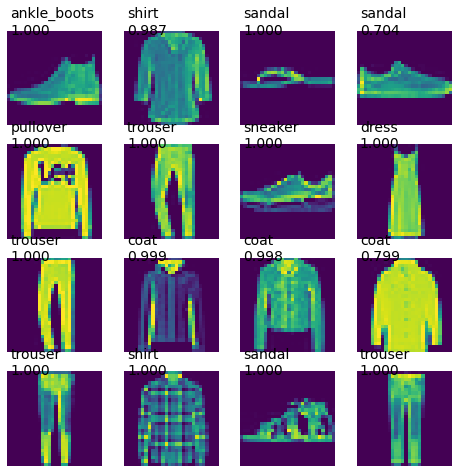

In [5]:
LABEL_NAMES = ['t_shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle_boots']


cpu_model = create_model()
cpu_model.load_weights('./fashion_mnist.h5')

from matplotlib import pyplot
%matplotlib inline

def plot_predictions(images, predictions):
  n = images.shape[0]
  nc = int(np.ceil(n / 4))
  f, axes = pyplot.subplots(nc, 4)
  for i in range(nc * 4):
    y = i // 4
    x = i % 4
    axes[x, y].axis('off')
    
    label = LABEL_NAMES[np.argmax(predictions[i])]
    confidence = np.max(predictions[i])
    if i > n:
      continue
    axes[x, y].imshow(images[i])
    axes[x, y].text(0.5, 0.5, label + '\n%.3f' % confidence, fontsize=14)

  pyplot.gcf().set_size_inches(8, 8)  

plot_predictions(np.squeeze(x_test[:16]), 
                 cpu_model.predict(x_test[:16]))